In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, SimpleRNN, GRU
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [3]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# 1. Data Downloading and Preparation
def download_data(max_retries=3, delay=5):
    ticker = "^GSPC"  # S&P 500 index
    for attempt in range(max_retries):
        try:
            data = yf.download(ticker, start="2018-01-01", end="2023-12-30")['Close']
            if data.empty:
                raise ValueError("Downloaded data is empty.")
            print(f"Successfully downloaded {len(data)} data points.")
            return data
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            if attempt < max_retries - 1:
                time.sleep(delay)  # Wait before retrying
            else:
                raise Exception("Max retries reached. Could not download data. Check ticker or network.")

def prepare_data(data, window_size=3):
    if len(data) == 0:
        raise ValueError("No data available to process.")
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
    
    X, y = [], []
    for i in range(len(scaled_data) - window_size):
        X.append(scaled_data[i:i + window_size])
        y.append(scaled_data[i + window_size])
    
    X = np.array(X)
    y = np.array(y)
    # Split into train (2018-01-01 to 2022-01-29) and test (2022-01-30 to 2023-12-29)
    train_size = int(len(X) * 0.68)  # Approx 68% as per paper
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return X_train, X_test, y_train, y_test, scaler

In [5]:
# 2. Model Definitions
def build_lstm():
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=(3, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_cnn():
    model = Sequential([
        Conv1D(64, kernel_size=2, activation='relu', input_shape=(3, 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_ann():
    model = Sequential([
        Dense(50, activation='relu', input_shape=(3, 1)),
        Flatten(),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_rnn():
    model = Sequential([
        SimpleRNN(50, activation='tanh', input_shape=(3, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru():
    model = Sequential([
        GRU(50, activation='tanh', input_shape=(3, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [6]:
# 3. Performance Metrics
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mape(y_true, y_pred, epsilon=1e-10):
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def calculate_directional_accuracy(y_true, y_pred):
    direction_true = np.sign(y_true[1:] - y_true[:-1])
    direction_pred = np.sign(y_pred[1:] - y_pred[:-1])
    return np.mean((direction_true == direction_pred)) * 100

In [7]:
# 4. Training and Evaluation
def train_and_evaluate(model, X_train, X_test, y_train, y_test, scaler, model_name):
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=500, batch_size=128, 
                        validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)
    
    # Predictions
    y_train_pred = model.predict(X_train, verbose=0)
    y_test_pred = model.predict(X_test, verbose=0)
    
    # Inverse transform predictions
    y_train_pred = scaler.inverse_transform(y_train_pred)
    y_test_pred = scaler.inverse_transform(y_test_pred)
    y_train_true = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate metrics
    rmse_train = calculate_rmse(y_train_true, y_train_pred)
    rmse_test = calculate_rmse(y_test_true, y_test_pred)
    mape_train = calculate_mape(y_train_true, y_train_pred)
    mape_test = calculate_mape(y_test_true, y_test_pred)
    da_train = calculate_directional_accuracy(y_train_true.flatten(), y_train_pred.flatten())
    da_test = calculate_directional_accuracy(y_test_true.flatten(), y_test_pred.flatten())
    
    print(f"\n{model_name} Results:")
    print(f"RMSE Train: {rmse_train:.4f}, RMSE Test: {rmse_test:.4f}")
    print(f"MAPE Train: {mape_train:.4f}%, MAPE Test: {mape_test:.4f}%")
    print(f"Directional Accuracy Train: {da_train:.2f}%, Test: {da_test:.2f}%")
    
    return y_train_pred, y_test_pred, history

In [8]:
# 5. Main Execution
try:
    data = download_data()
    X_train, X_test, y_train, y_test, scaler = prepare_data(data)

    models = {
        "LSTM": build_lstm(),
        "CNN": build_cnn(),
        "ANN": build_ann(),
        "RNN": build_rnn(),
        "GRU": build_gru()
    }

    results = {}
    for name, model in models.items():
        y_train_pred, y_test_pred, history = train_and_evaluate(model, X_train, X_test, y_train, y_test, scaler, name)
        results[name] = (y_train_pred, y_test_pred, history)

except Exception as e:
    print(f"Error occurred: {e}")

[*********************100%***********************]  1 of 1 completed
C:\Users\harsh\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\harsh\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully downloaded 1509 data points.


C:\Users\harsh\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



LSTM Results:
RMSE Train: 45.1571, RMSE Test: 61.9312
MAPE Train: 0.9523%, MAPE Test: 1.1843%
Directional Accuracy Train: 51.12%, Test: 48.23%

CNN Results:
RMSE Train: 47.1597, RMSE Test: 62.9845
MAPE Train: 0.9914%, MAPE Test: 1.2114%
Directional Accuracy Train: 51.71%, Test: 49.69%

ANN Results:
RMSE Train: 40.4022, RMSE Test: 54.5934
MAPE Train: 0.8473%, MAPE Test: 1.0486%
Directional Accuracy Train: 51.03%, Test: 46.78%

RNN Results:
RMSE Train: 39.6852, RMSE Test: 53.8011
MAPE Train: 0.8522%, MAPE Test: 1.0372%
Directional Accuracy Train: 49.66%, Test: 48.23%

GRU Results:
RMSE Train: 43.5411, RMSE Test: 58.8429
MAPE Train: 0.9184%, MAPE Test: 1.1281%
Directional Accuracy Train: 51.81%, Test: 47.61%


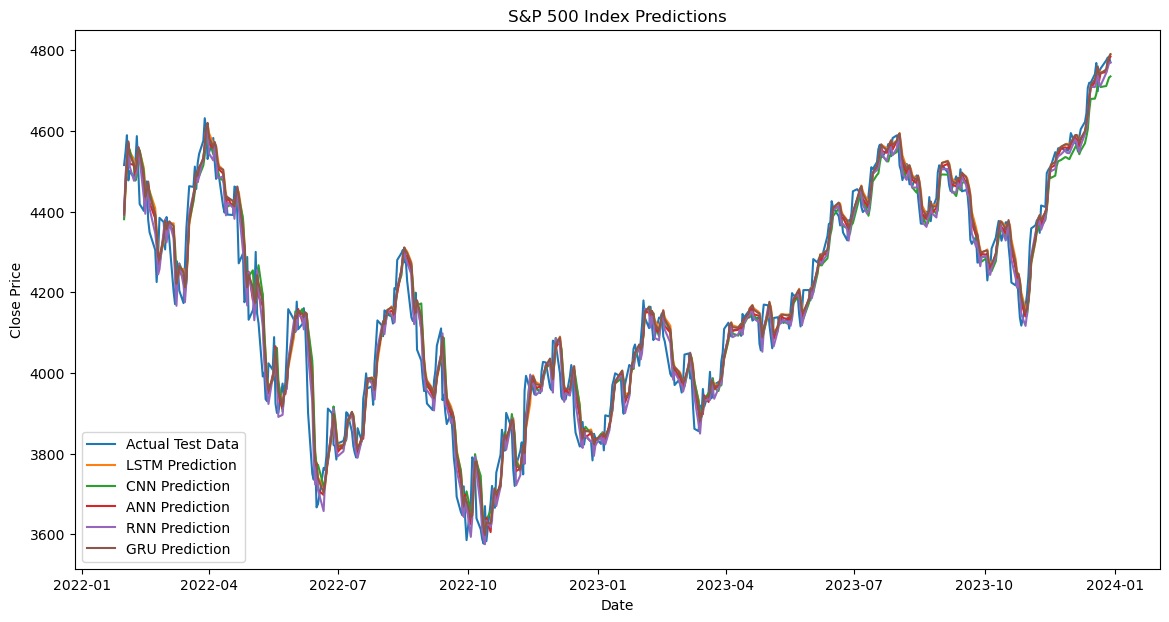

In [10]:
# 6. Visualization
try:
    plt.figure(figsize=(14, 7))
    plt.plot(data.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Test Data')
    for name, (_, y_test_pred, _) in results.items():
        plt.plot(data.index[-len(y_test):], y_test_pred, label=f'{name} Prediction')
    plt.legend()
    plt.title('S&P 500 Index Predictions')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()

except Exception as e:
    print(f"Error occurred: {e}")
